## Baseline - Margin

/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module
Random State가  1  일 때  Basic model:  0.7117786790661426
Split_ratio:  0.2 이고 Random State가  1  일 때  Baseline model split ratio 0.2:  0.7173237554265578
Random State가  1  일 때  Advance model:  0.7434110910670875
Random State가  2  일 때  Basic model:  0.7222601878308449
Split_ratio:  0.2 이고 Random State가  2  일 때  Baseline model split ratio 0.2:  0.7314385745989297
Random State가  2  일 때  Advance model:  0.7436141885088061
Random State가  3  일 때  Basic model:  0.7342754966548315
Split_ratio:  0.2 이고 Random State가  3  일 때  Baseline model split ratio 0.2:  0.7331214496600468
Random State가  3  일 때  Advance model:  0.7394576193585036
Random State가  4  일 때  Basic model:  0.715613091933907
Split_ratio:  0.2 이고 Random State가  4  일 때  Baseline model split ratio 0.2:  0.7167493254052764
Random State가  4  일 때  Advance model:  0.7094461881137997
Random State가  5  일 때  Basic model:  0.7340625739286158
Split_ratio:  0.2 이고 Random State가  5  일 때  B

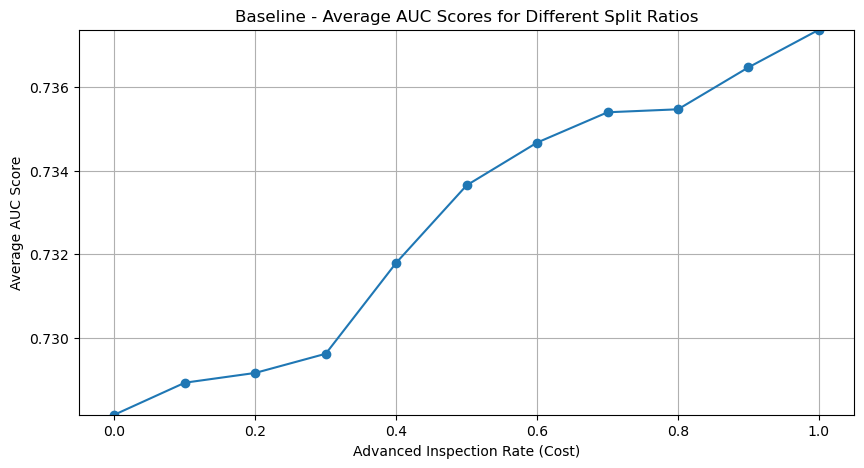

In [1]:
### 필요한 라이브러리 불러오기

import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import warnings 
warnings.filterwarnings('ignore') 
from scipy import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import random 
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader



# 설치된 모듈 경로로 이동하기

%cd /home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module

# 모듈 함수 불러오기

from split_and_predict_uncertainty import split_and_predict_uncertainty
from seed_everything import seed_everything
from test_predict import test_predict

#### Advance inspection ratio에 따른 Test data의 AUC 구하는 함수 만들기


#---------------------------------------------------------------------------------------------------------------------------------------------------------------#
# 난수 고정

seed_everything(42)

# Define the range of random states

random_states = range(1, 31)

# Advance inspection ratio 정의

split_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

auc_scores_Baseline_margin = np.zeros((len(random_states), len(split_ratios)))



# 데이터 업로드

df = pd.read_csv('/home/iai/heo/recipe2/activeinspection_recipe2.csv')
X=df.iloc[:,3:-1].values
Y=df.iloc[:,-1].values
data_X = pd.DataFrame(X)
data_Y = pd.DataFrame(Y)
data_Y = data_Y.rename(columns={0: '0.1'})

# 난수 고정
seed_everything(42)

# advance model(teacher model)에 사용될 feature

teacher_model_features=len(list(data_X.columns)) # 99

# advance model(teacher model) 정의하기

class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=teacher_model_features,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2)
        )
    def forward(self, x):
        output=self.classifier(x)
        return output



# student model(basic model)에서 사용될 feature

test_stage_features=[0,1,2,3,4,5,6,7]
student_model_features=len(test_stage_features)
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=8,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2),
        )
    def forward(self, x):
        output=self.classifier(x)
        return output  


# 하이퍼파라미터 세팅

learning_rate = 0.01
num_epochs = 200


# loss function - crossentropy()함수

a=986/(244020+986)
b=244020/(244020+986)
weights=[a,b]
weights=torch.FloatTensor(weights)

criterion = nn.CrossEntropyLoss(weights)

# 30회 반복시 preliminary experiment( AUC 평균, 표준편차 )의 결과를 계산하기 위한 리스트

auc_score30_split_Baseline=[]
auc_score30_split_Baseline_0_2=[]
auc_score30_split_ad_BL=[]


#-------------------------------------------------------------------------------------------------------------------------------------------------
# 학습이 다음 순으로 진행됩니다.

# 1.기본 설정

#여러 다양한 초기 랜덤 상태에 대해 실험을 진행합니다. 이 때, random_states 값은 1부터 30까지 설정됩니다.

# 2.데이터 처리

# 데이터를 학습, 검증, 테스트 데이터로 분리합니다.
# 데이터를 정규화합니다.
# 데이터를 PyTorch의 Tensor로 변환하고 DataLoader를 설정합니다.

# 3.선생님 모델 학습 (Advance 모델)

# 이 모델은 주어진 데이터로 학습을 진행하며, 각 에포크마다 학습 및 검증 손실을 계산합니다.
# 조기 종료(early stopping) 메커니즘이 적용됩니다. 연속적으로 모델 성능 향상이 없을 경우 학습이 조기 종료될 수 있습니다.

# 4.학생 모델 학습 (기본 모델)

# 학생 모델도 같은 방식으로 학습되지만, 선생님 모델과는 다른 입력 특성을 사용할 수 있습니다.
# 학생 모델도 조기 종료 메커니즘을 사용합니다.

# 5. 불확실성 평가

# 테스트 데이터를 사용하여 학생 모델의 예측값을 생성합니다.
# 이 예측값의 불확실성을 평가하기 위해 Biased Margin을 계산합니다. Biased Margin은 예측 확률의 차이를 의미합니다.
# 불확실성 점수를 기준으로 데이터를 여러 비율로 분할합니다. 예를 들어, 가장 불확실성이 높은 상위 10% 데이터, 상위 20% 데이터 등으로 분할됩니다.

# 6.분할 데이터의 성능 평가

# 분할된 각 데이터 집합에 대해 선생님 모델의 성능 (AUC)을 평가합니다.

#-------------------------------------------------------------------------------------------------------------------------------------------------------------


random_states=range(1, 31)

# 30회 반복 실험
for i,random_state in enumerate(random_states):

    # 데이터 분할
    
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_Y, test_size=0.5, random_state=random_state, shuffle=True, stratify=data_Y)
    train_X, val_X, train_y, val_y=train_test_split(train_X,train_y,test_size=1/5, random_state=random_state,shuffle=True, stratify=train_y)
    
    # 데이터 정규화
    
    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    val_X_scaled=scaler.transform(val_X)
    test_X_scaled = scaler.transform(test_X)
    
    # 데이터들을 파이토치 텐서로 변환 

    train_X_tensor=torch.tensor(train_X_scaled,dtype=torch.float32)
    train_y_tensor=torch.tensor(np.array(train_y),dtype=torch.long)
    val_X_tensor=torch.tensor(val_X_scaled, dtype=torch.float32)
    val_y_tensor=torch.tensor(np.array(val_y),dtype=torch.long)
    test_X_tensor=torch.tensor(test_X_scaled,dtype=torch.float32)
    test_y_tensor=torch.tensor(np.array(test_y),dtype=torch.long)
    
    train_tensorboard=TensorDataset(train_X_tensor,train_y_tensor)
    val_tensorboard=TensorDataset(val_X_tensor,val_y_tensor)
    test_tensorboard=TensorDataset(test_X_tensor,test_y_tensor)
    
    # 배치사이즈의 크기는 학습 데이터셋의 절반 크기로 함
    
    batch_size=4900
    
    # 데이터 로더 만들어주기
    
    train_loader=DataLoader(train_tensorboard,batch_size=batch_size,shuffle=True,drop_last=True)
    val_loader=DataLoader(val_tensorboard,batch_size=batch_size,shuffle=False)
    test_loader=DataLoader(test_tensorboard,batch_size=batch_size,shuffle=False)
    
    #--------------------------------------------------------------------------------------------------------#
    # optimizer 정의
    teacher_model = Teacher()
    student_model = Student()
    optimizer_advance = optim.Adam(teacher_model.parameters(), lr=learning_rate)
    optimizer_basic = optim.Adam(student_model.parameters(), lr=learning_rate)
    
    # Teacher model (advanced model 구하기)    
    
    best_teacher_model=torch.load('/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/advance_model_recipe2/advancemodel_randomstate{}'.format(i))  

    best_student_model=torch.load('/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/basic_model_recipe2/basicmodel_randomstate{}'.format(i))
            
    y_predictions=test_predict(best_student_model,"best_student_model",test_loader)
    

    # 테스트 데이터의 입력(X)와 라벨(y)을 결합
    test_data=pd.concat([test_X,test_y],axis=1)

    # Margin을 계산하여 uncertainty score로 사용 
    
    # Margin은 예측 확률 사이의 차이로 계산 (예: abs(probability of class 1- probability of class 0))
    
    uncertainty_scores=1/np.abs(y_predictions-0.5)
    test_data['predictions']=y_predictions 
    test_data['uncertainty_scores']=uncertainty_scores 
        
    # Uncertainty 기준으로 데이터프레임 정렬하기
    test_data=test_data.sort_values(by='uncertainty_scores',ascending=False)
        
    test_y=test_data['0.1']   
    # split_ratios에 대해 반복
    for j, split_ratio in enumerate(split_ratios):
        # 주어진 분할 비율에 따른 AUC를 계산
        auc_score = split_and_predict_uncertainty(test_data, best_teacher_model, test_y, split_ratio,scaler,batch_size)
        # 결과 AUC를 저장
        auc_scores_Baseline_margin[i, j] = auc_score
        # 분할 비율이 0일 때의 결과 출력 (Basic 모델)
        if split_ratio==0:
            auc_score30_split_Baseline.append(auc_score)
            print("Random State가 ",i+1," 일 때 ", "Basic model: ",auc_score)
        if split_ratio==0.2:
            auc_score30_split_Baseline_0_2.append(auc_score)
            print("Split_ratio: ",split_ratio, "이고 Random State가 ",i+1," 일 때 ", "Baseline model split ratio 0.2: ",auc_score)
        # 분할 비율이 1일 때의 결과 출력 (Advance 모델)
        if split_ratio==1:
            auc_score30_split_ad_BL.append(auc_score)
            print("Random State가 ", i+1," 일 때 ","Advance model: ",auc_score)
            
# Calculate the average AUC scores

average_auc_scores_Baseline_margin = auc_scores_Baseline_margin.mean(axis=0)   


plt.figure(figsize=(10, 5))
plt.plot(split_ratios, average_auc_scores_Baseline_margin, marker='o')
plt.title('Baseline - Average AUC Scores for Different Split Ratios')
plt.xlabel('Advanced Inspection Rate (Cost)')
plt.ylabel('Average AUC Score')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim(min(average_auc_scores_Baseline_margin), max(average_auc_scores_Baseline_margin))
plt.grid()
plt.show()   



In [5]:
average_auc_scores_Baseline_margin

array([0.72816782, 0.72893296, 0.72916692, 0.72962509, 0.73179851,
       0.73365059, 0.7346722 , 0.73539652, 0.73546769, 0.73647016,
       0.73736964])

In [3]:

# Baseline 모델의 30회 반복 실험 평균값

print(np.mean(np.array(auc_score30_split_Baseline)))

# Baseline 모델의 30회 반복 실험 표준편차

print(np.std(np.array(auc_score30_split_Baseline)))


0.7281678177433554
0.01013601792127551


In [4]:

# Advance 모델의 30회 반복 실험 평균값

print(np.mean(np.array(auc_score30_split_ad_BL)))

# Advance 모델의 30회 반복 실험 표준편차

print(np.std(np.array(auc_score30_split_ad_BL)))

0.7373696430517921
0.010575167677490668


## Margin - Knowledge distillation (T=1)

/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module
Random State가  1  일 때  T가 1일 때 KD model:  0.7253644457367492
Split_ratio:  0.2 이고 Random State가  1  일 때  model split ratio 0.2:  0.7287669284581302
Random State가  1  일 때  Advance model:  0.743411082754664
Random State가  2  일 때  T가 1일 때 KD model:  0.7285176804415161
Split_ratio:  0.2 이고 Random State가  2  일 때  model split ratio 0.2:  0.7385228457814368
Random State가  2  일 때  Advance model:  0.7436141885088061
Random State가  3  일 때  T가 1일 때 KD model:  0.7381882208637505
Split_ratio:  0.2 이고 Random State가  3  일 때  model split ratio 0.2:  0.7352818568224964
Random State가  3  일 때  Advance model:  0.7394576027336568
Random State가  4  일 때  T가 1일 때 KD model:  0.7166575313133147
Split_ratio:  0.2 이고 Random State가  4  일 때  model split ratio 0.2:  0.7156917523968458
Random State가  4  일 때  Advance model:  0.7094461881137997
Random State가  5  일 때  T가 1일 때 KD model:  0.7349142897707484
Split_ratio:  0.2 이고 Random State가  5  일 때  model split 

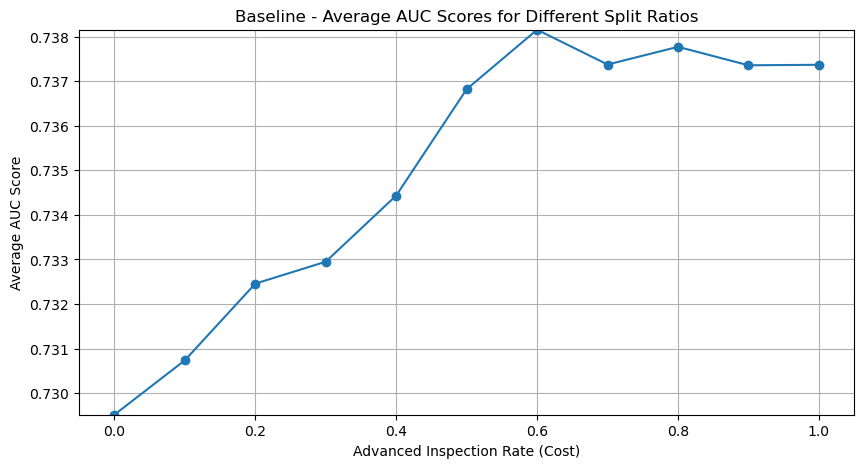

In [6]:
### 필요한 라이브러리 불러오기

import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import warnings 
warnings.filterwarnings('ignore') 
from scipy import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import random 
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader



# 설치된 모듈 경로로 이동하기

%cd /home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module

# 모듈 함수 불러오기

from split_and_predict_uncertainty import split_and_predict_uncertainty
from seed_everything import seed_everything
from test_predict import test_predict

#### Advance inspection ratio에 따른 Test data의 AUC 구하는 함수 만들기


#---------------------------------------------------------------------------------------------------------------------------------------------------------------#


# Define the range of random states

random_states = range(1, 31)

# Advance inspection ratio 정의

split_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

auc_scores_KD_margin_t1 = np.zeros((len(random_states), len(split_ratios)))



# 데이터 업로드

df = pd.read_csv('/home/iai/heo/recipe2/activeinspection_recipe2.csv')
X=df.iloc[:,3:-1].values
Y=df.iloc[:,-1].values
data_X = pd.DataFrame(X)
data_Y = pd.DataFrame(Y)
data_Y = data_Y.rename(columns={0: '0.1'})


# advance model(teacher model)에 사용될 feature

teacher_model_features=len(list(data_X.columns)) # 99

# advance model(teacher model) 정의하기

class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=teacher_model_features,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2)
        )
    def forward(self, x):
        output=self.classifier(x)
        return output



# student model(basic model)에서 사용될 feature

test_stage_features=[0,1,2,3,4,5,6,7]
student_model_features=len(test_stage_features)
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=8,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2),
        )
    def forward(self, x):
        output=self.classifier(x)
        return output  


# 하이퍼파라미터 세팅

learning_rate = 0.01
num_epochs = 200


# loss function - crossentropy()함수

a=986/(244020+986)
b=244020/(244020+986)
weights=[a,b]
weights=torch.FloatTensor(weights)

criterion = nn.CrossEntropyLoss(weights)

# 30회 반복시 preliminary experiment( AUC 평균, 표준편차 )의 결과를 계산하기 위한 리스트

auc_score30_split_KD_t1=[]
auc_score30_split_KD_0_2_t1=[]
auc_score30_split_ad_KD_t1=[]


#-------------------------------------------------------------------------------------------------------------------------------------------------
# 학습이 다음 순으로 진행됩니다.

# 1.기본 설정

#여러 다양한 초기 랜덤 상태에 대해 실험을 진행합니다. 이 때, random_states 값은 1부터 30까지 설정됩니다.

# 2.데이터 처리

# 데이터를 학습, 검증, 테스트 데이터로 분리합니다.
# 데이터를 정규화합니다.
# 데이터를 PyTorch의 Tensor로 변환하고 DataLoader를 설정합니다.

# 3.선생님 모델 학습 (Advance 모델)

# 이 모델은 주어진 데이터로 학습을 진행하며, 각 에포크마다 학습 및 검증 손실을 계산합니다.
# 조기 종료(early stopping) 메커니즘이 적용됩니다. 연속적으로 모델 성능 향상이 없을 경우 학습이 조기 종료될 수 있습니다.

# 4.학생 모델 학습 (기본 모델)

# 학생 모델도 같은 방식으로 학습되지만, 선생님 모델과는 다른 입력 특성을 사용할 수 있습니다.
# 학생 모델도 조기 종료 메커니즘을 사용합니다.

# 5. 불확실성 평가

# 테스트 데이터를 사용하여 학생 모델의 예측값을 생성합니다.
# 이 예측값의 불확실성을 평가하기 위해 Biased Margin을 계산합니다. Biased Margin은 예측 확률의 차이를 의미합니다.
# 불확실성 점수를 기준으로 데이터를 여러 비율로 분할합니다. 예를 들어, 가장 불확실성이 높은 상위 10% 데이터, 상위 20% 데이터 등으로 분할됩니다.

# 6.분할 데이터의 성능 평가

# 분할된 각 데이터 집합에 대해 선생님 모델의 성능 (AUC)을 평가합니다.

#-------------------------------------------------------------------------------------------------------------------------------------------------------------


random_states=range(1, 31)

# 30회 반복 실험
for i,random_state in enumerate(random_states):

    # 데이터 분할
    
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_Y, test_size=0.5, random_state=random_state, shuffle=True, stratify=data_Y)
    train_X, val_X, train_y, val_y=train_test_split(train_X,train_y,test_size=1/5, random_state=random_state,shuffle=True, stratify=train_y)
    
    # 데이터 정규화
    
    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    val_X_scaled=scaler.transform(val_X)
    test_X_scaled = scaler.transform(test_X)
    
    # 데이터들을 파이토치 텐서로 변환 

    train_X_tensor=torch.tensor(train_X_scaled,dtype=torch.float32)
    train_y_tensor=torch.tensor(np.array(train_y),dtype=torch.long)
    val_X_tensor=torch.tensor(val_X_scaled, dtype=torch.float32)
    val_y_tensor=torch.tensor(np.array(val_y),dtype=torch.long)
    test_X_tensor=torch.tensor(test_X_scaled,dtype=torch.float32)
    test_y_tensor=torch.tensor(np.array(test_y),dtype=torch.long)
    
    train_tensorboard=TensorDataset(train_X_tensor,train_y_tensor)
    val_tensorboard=TensorDataset(val_X_tensor,val_y_tensor)
    test_tensorboard=TensorDataset(test_X_tensor,test_y_tensor)
    
    # 배치사이즈의 크기는 학습 데이터셋의 절반 크기로 함
    
    batch_size=4900
    
    # 데이터 로더 만들어주기
    
    train_loader=DataLoader(train_tensorboard,batch_size=batch_size,shuffle=True,drop_last=True)
    val_loader=DataLoader(val_tensorboard,batch_size=batch_size,shuffle=False)
    test_loader=DataLoader(test_tensorboard,batch_size=batch_size,shuffle=False)
    
    #--------------------------------------------------------------------------------------------------------#
    
    # Teacher model (advanced model 구하기)    
    
    best_teacher_model=torch.load('/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/advance_model_recipe2/advancemodel_randomstate{}'.format(i))  

    best_student_model=torch.load('/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/temperature1_kd_model_recipe2/temperature1_kd_basicmodel_randomstate{}'.format(i))
            
    y_predictions=test_predict(best_student_model,"best_student_model",test_loader)

    # Margin을 계산하여 uncertainty score로 사용 
    
    # Margin은 예측 확률 사이의 차이로 계산 (예: abs(probability of class 1- probability of class 0))
    
    uncertainty_scores=1/np.abs(y_predictions-0.5)
    
    # 테스트 데이터의 입력(X)와 라벨(y)을 결합
    
    test_data=pd.concat([test_X,test_y],axis=1)
    
    # 예측값을 numpy 배열로 변환    
   
    
    test_data['predictions']=y_predictions 
    test_data['uncertainty_scores']=uncertainty_scores 
        
    # Uncertainty 기준으로 데이터프레임 정렬하기
    test_data=test_data.sort_values(by='uncertainty_scores',ascending=False)
        
    test_y=test_data['0.1']   
    # split_ratios에 대해 반복
    for j, split_ratio in enumerate(split_ratios):
        # 주어진 분할 비율에 따른 AUC를 계산
        auc_score = split_and_predict_uncertainty(test_data, best_teacher_model, test_y, split_ratio,scaler,batch_size)
        # 결과 AUC를 저장
        auc_scores_KD_margin_t1[i, j] = auc_score
        # 분할 비율이 0일 때의 결과 출력 (Basic 모델)
        if split_ratio==0:
            auc_score30_split_KD_t1.append(auc_score)
            print("Random State가 ",i+1," 일 때 ", "T가 1일 때 KD model: ",auc_score)
        if split_ratio==0.2:
            auc_score30_split_KD_0_2_t1.append(auc_score)
            print("Split_ratio: ",split_ratio, "이고 Random State가 ",i+1," 일 때 ", "model split ratio 0.2: ",auc_score)
        # 분할 비율이 1일 때의 결과 출력 (Advance 모델)
        if split_ratio==1:
            auc_score30_split_ad_KD_t1.append(auc_score)
            print("Random State가 ", i+1," 일 때 ","Advance model: ",auc_score)
            
# Calculate the average AUC scores

average_auc_scores_KD_margin_t1 = auc_scores_KD_margin_t1.mean(axis=0)   


plt.figure(figsize=(10, 5))
plt.plot(split_ratios, average_auc_scores_KD_margin_t1, marker='o')
plt.title('Baseline - Average AUC Scores for Different Split Ratios')
plt.xlabel('Advanced Inspection Rate (Cost)')
plt.ylabel('Average AUC Score')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim(min(average_auc_scores_KD_margin_t1), max(average_auc_scores_KD_margin_t1))
plt.grid()
plt.show()   


In [7]:
average_auc_scores_KD_margin_t1

array([0.72951437, 0.73073556, 0.73245707, 0.73294892, 0.73443452,
       0.73682165, 0.73815687, 0.73737545, 0.73777267, 0.73735859,
       0.73736964])

## Margin - Knowledge distillation (T=2)

/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module


Random State가  1  일 때  T가 2일 때 KD model:  0.7250591221116613
Split_ratio:  0.2 이고 Random State가  1  일 때  model split ratio 0.2:  0.7283073678162582
Random State가  1  일 때  Advance model:  0.7434110910670874
Random State가  2  일 때  T가 2일 때 KD model:  0.7292882919682206
Split_ratio:  0.2 이고 Random State가  2  일 때  model split ratio 0.2:  0.7382985433475426
Random State가  2  일 때  Advance model:  0.7436141885088061
Random State가  3  일 때  T가 2일 때 KD model:  0.7365877634809636
Split_ratio:  0.2 이고 Random State가  3  일 때  model split ratio 0.2:  0.7394272540757059
Random State가  3  일 때  Advance model:  0.7394576193585036
Random State가  4  일 때  T가 2일 때 KD model:  0.7151410460320398
Split_ratio:  0.2 이고 Random State가  4  일 때  model split ratio 0.2:  0.7158537449046922
Random State가  4  일 때  Advance model:  0.7094461881137997
Random State가  5  일 때  T가 2일 때 KD model:  0.7300399096073826
Split_ratio:  0.2 이고 Random State가  5  일 때  model split ratio 0.2:  0.7355036821542078
Random State가  5  일 때  Advan

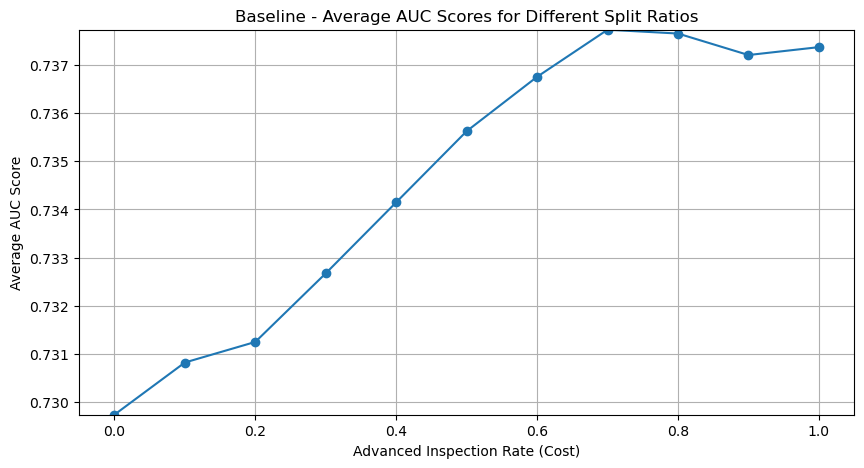

In [8]:
### 필요한 라이브러리 불러오기

import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import warnings 
warnings.filterwarnings('ignore') 
from scipy import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import random 
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader



# 설치된 모듈 경로로 이동하기

%cd /home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module

# 모듈 함수 불러오기

from split_and_predict_uncertainty import split_and_predict_uncertainty
from seed_everything import seed_everything
from test_predict import test_predict

#### Advance inspection ratio에 따른 Test data의 AUC 구하는 함수 만들기


#---------------------------------------------------------------------------------------------------------------------------------------------------------------#


# Define the range of random states

random_states = range(1, 31)

# Advance inspection ratio 정의

split_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

auc_scores_KD_margin_t2 = np.zeros((len(random_states), len(split_ratios)))



# 데이터 업로드

df = pd.read_csv('/home/iai/heo/recipe2/activeinspection_recipe2.csv')
X=df.iloc[:,3:-1].values
Y=df.iloc[:,-1].values
data_X = pd.DataFrame(X)
data_Y = pd.DataFrame(Y)
data_Y = data_Y.rename(columns={0: '0.1'})


# advance model(teacher model)에 사용될 feature

teacher_model_features=len(list(data_X.columns)) # 99

# advance model(teacher model) 정의하기

class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=teacher_model_features,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2)
        )
    def forward(self, x):
        output=self.classifier(x)
        return output



# student model(basic model)에서 사용될 feature

test_stage_features=[0,1,2,3,4,5,6,7]
student_model_features=len(test_stage_features)
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=8,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2),
        )
    def forward(self, x):
        output=self.classifier(x)
        return output  


# 하이퍼파라미터 세팅

learning_rate = 0.01
num_epochs = 200


# loss function - crossentropy()함수

a=986/(244020+986)
b=244020/(244020+986)
weights=[a,b]
weights=torch.FloatTensor(weights)

criterion = nn.CrossEntropyLoss(weights)

# 30회 반복시 preliminary experiment( AUC 평균, 표준편차 )의 결과를 계산하기 위한 리스트

auc_score30_split_KD_t2=[]
auc_score30_split_KD_0_2_t2=[]
auc_score30_split_ad_KD_t2=[]


#-------------------------------------------------------------------------------------------------------------------------------------------------
# 학습이 다음 순으로 진행됩니다.

# 1.기본 설정

#여러 다양한 초기 랜덤 상태에 대해 실험을 진행합니다. 이 때, random_states 값은 1부터 30까지 설정됩니다.

# 2.데이터 처리

# 데이터를 학습, 검증, 테스트 데이터로 분리합니다.
# 데이터를 정규화합니다.
# 데이터를 PyTorch의 Tensor로 변환하고 DataLoader를 설정합니다.

# 3.선생님 모델 학습 (Advance 모델)

# 이 모델은 주어진 데이터로 학습을 진행하며, 각 에포크마다 학습 및 검증 손실을 계산합니다.
# 조기 종료(early stopping) 메커니즘이 적용됩니다. 연속적으로 모델 성능 향상이 없을 경우 학습이 조기 종료될 수 있습니다.

# 4.학생 모델 학습 (기본 모델)

# 학생 모델도 같은 방식으로 학습되지만, 선생님 모델과는 다른 입력 특성을 사용할 수 있습니다.
# 학생 모델도 조기 종료 메커니즘을 사용합니다.

# 5. 불확실성 평가

# 테스트 데이터를 사용하여 학생 모델의 예측값을 생성합니다.
# 이 예측값의 불확실성을 평가하기 위해 Biased Margin을 계산합니다. Biased Margin은 예측 확률의 차이를 의미합니다.
# 불확실성 점수를 기준으로 데이터를 여러 비율로 분할합니다. 예를 들어, 가장 불확실성이 높은 상위 10% 데이터, 상위 20% 데이터 등으로 분할됩니다.

# 6.분할 데이터의 성능 평가

# 분할된 각 데이터 집합에 대해 선생님 모델의 성능 (AUC)을 평가합니다.

#-------------------------------------------------------------------------------------------------------------------------------------------------------------


random_states=range(1, 31)

# 30회 반복 실험
for i,random_state in enumerate(random_states):

    # 데이터 분할
    
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_Y, test_size=0.5, random_state=random_state, shuffle=True, stratify=data_Y)
    train_X, val_X, train_y, val_y=train_test_split(train_X,train_y,test_size=1/5, random_state=random_state,shuffle=True, stratify=train_y)
    
    # 데이터 정규화
    
    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    val_X_scaled=scaler.transform(val_X)
    test_X_scaled = scaler.transform(test_X)
    
    # 데이터들을 파이토치 텐서로 변환 

    train_X_tensor=torch.tensor(train_X_scaled,dtype=torch.float32)
    train_y_tensor=torch.tensor(np.array(train_y),dtype=torch.long)
    val_X_tensor=torch.tensor(val_X_scaled, dtype=torch.float32)
    val_y_tensor=torch.tensor(np.array(val_y),dtype=torch.long)
    test_X_tensor=torch.tensor(test_X_scaled,dtype=torch.float32)
    test_y_tensor=torch.tensor(np.array(test_y),dtype=torch.long)
    
    train_tensorboard=TensorDataset(train_X_tensor,train_y_tensor)
    val_tensorboard=TensorDataset(val_X_tensor,val_y_tensor)
    test_tensorboard=TensorDataset(test_X_tensor,test_y_tensor)
    
    # 배치사이즈의 크기는 학습 데이터셋의 절반 크기로 함
    
    batch_size=4900
    
    # 데이터 로더 만들어주기
    
    train_loader=DataLoader(train_tensorboard,batch_size=batch_size,shuffle=True,drop_last=True)
    val_loader=DataLoader(val_tensorboard,batch_size=batch_size,shuffle=False)
    test_loader=DataLoader(test_tensorboard,batch_size=batch_size,shuffle=False)
    
    #--------------------------------------------------------------------------------------------------------#
    
    # Teacher model (advanced model 구하기)    
    
    best_teacher_model=torch.load('/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/advance_model_recipe2/advancemodel_randomstate{}'.format(i)) 

    best_student_model=torch.load('/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/temperature2_kd_model_recipe2/temperature2_kd_basicmodel_randomstate{}'.format(i))
            

    y_predictions=test_predict(best_student_model,"best_student_model",test_loader)

    # Margin을 계산하여 uncertainty score로 사용 
    
    # Margin은 예측 확률 사이의 차이로 계산 (예: abs(probability of class 1- probability of class 0))
    
    uncertainty_scores=1/np.abs(y_predictions-0.5)
    
    # 테스트 데이터의 입력(X)와 라벨(y)을 결합
    
    test_data=pd.concat([test_X,test_y],axis=1)
    
    # 예측값을 numpy 배열로 변환    
   
    
    test_data['predictions']=y_predictions 
    test_data['uncertainty_scores']=uncertainty_scores 
        
    # Uncertainty 기준으로 데이터프레임 정렬하기
    test_data=test_data.sort_values(by='uncertainty_scores',ascending=False)
        
    test_y=test_data['0.1']   
    # split_ratios에 대해 반복
    for j, split_ratio in enumerate(split_ratios):
        # 주어진 분할 비율에 따른 AUC를 계산
        auc_score = split_and_predict_uncertainty(test_data, best_teacher_model, test_y, split_ratio,scaler,batch_size)
        # 결과 AUC를 저장
        auc_scores_KD_margin_t2[i, j] = auc_score
        # 분할 비율이 0일 때의 결과 출력 (Basic 모델)
        if split_ratio==0:
            auc_score30_split_KD_t2.append(auc_score)
            print("Random State가 ",i+1," 일 때 ", "T가 2일 때 KD model: ",auc_score)
        if split_ratio==0.2:
            auc_score30_split_KD_0_2_t2.append(auc_score)
            print("Split_ratio: ",split_ratio, "이고 Random State가 ",i+1," 일 때 ", "model split ratio 0.2: ",auc_score)
        # 분할 비율이 1일 때의 결과 출력 (Advance 모델)
        if split_ratio==1:
            auc_score30_split_ad_KD_t2.append(auc_score)
            print("Random State가 ", i+1," 일 때 ","Advance model: ",auc_score)
            
# Calculate the average AUC scores

average_auc_scores_KD_margin_t2 = auc_scores_KD_margin_t2.mean(axis=0)   


plt.figure(figsize=(10, 5))
plt.plot(split_ratios, average_auc_scores_KD_margin_t2, marker='o')
plt.title('Baseline - Average AUC Scores for Different Split Ratios')
plt.xlabel('Advanced Inspection Rate (Cost)')
plt.ylabel('Average AUC Score')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim(min(average_auc_scores_KD_margin_t2), max(average_auc_scores_KD_margin_t2))
plt.grid()
plt.show()   


In [9]:
average_auc_scores_KD_margin_t2

array([0.72974015, 0.73082361, 0.73125072, 0.73267455, 0.73414878,
       0.73562508, 0.73675365, 0.73773094, 0.73765165, 0.73720563,
       0.73736964])

In [10]:
# T가 2일 때 KD 모델의 30회 반복 실험 평균값

print(np.mean(np.array(auc_score30_split_KD_t2)))

# KD 모델의 30회 반복 실험 표준편차

print(np.std(np.array(auc_score30_split_KD_t2)))

0.7297401456081671
0.008477842976178427


## Margin - Knowledge distillation (T=5)

/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module


Random State가  1  일 때  T가 5일 때 KD model:  0.7248257009492621
Split_ratio:  0.2 이고 Random State가  1  일 때  model split ratio 0.2:  0.7293489144723115
Random State가  1  일 때  Advance model:  0.7434110910670875
Random State가  2  일 때  T가 5일 때 KD model:  0.7301743796812452
Split_ratio:  0.2 이고 Random State가  2  일 때  model split ratio 0.2:  0.7393925330830295
Random State가  2  일 때  Advance model:  0.7436141885088061
Random State가  3  일 때  T가 5일 때 KD model:  0.7383442450515728
Split_ratio:  0.2 이고 Random State가  3  일 때  model split ratio 0.2:  0.736608062418985
Random State가  3  일 때  Advance model:  0.7394576276709273
Random State가  4  일 때  T가 5일 때 KD model:  0.7179057165034689
Split_ratio:  0.2 이고 Random State가  4  일 때  model split ratio 0.2:  0.7188228178683189
Random State가  4  일 때  Advance model:  0.7094461881137997
Random State가  5  일 때  T가 5일 때 KD model:  0.7319071375953788
Split_ratio:  0.2 이고 Random State가  5  일 때  model split ratio 0.2:  0.7382677790684201
Random State가  5  일 때  Advanc

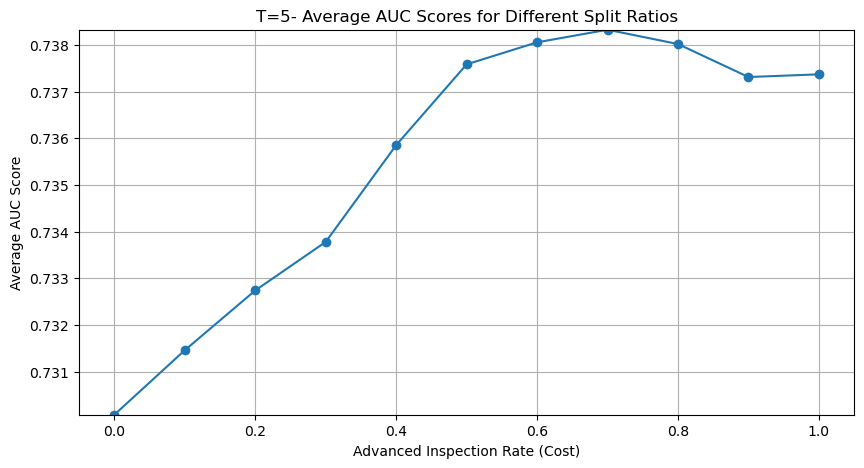

In [11]:
### 필요한 라이브러리 불러오기

import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import warnings 
warnings.filterwarnings('ignore') 
from scipy import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import random 
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader



# 설치된 모듈 경로로 이동하기

%cd /home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module

# 모듈 함수 불러오기

from split_and_predict_uncertainty import split_and_predict_uncertainty
from seed_everything import seed_everything
from test_predict import test_predict

#### Advance inspection ratio에 따른 Test data의 AUC 구하는 함수 만들기


#---------------------------------------------------------------------------------------------------------------------------------------------------------------#

## 난수 고정하기

seed_everything(42)
# Define the range of random states

random_states = range(1, 31)

# Advance inspection ratio 정의

split_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

auc_scores_KD_margin_t5 = np.zeros((len(random_states), len(split_ratios)))



# 데이터 업로드

df = pd.read_csv('/home/iai/heo/recipe2/activeinspection_recipe2.csv')
X=df.iloc[:,3:-1].values
Y=df.iloc[:,-1].values
data_X = pd.DataFrame(X)
data_Y = pd.DataFrame(Y)
data_Y = data_Y.rename(columns={0: '0.1'})



# advance model(teacher model)에 사용될 feature

teacher_model_features=len(list(data_X.columns)) # 99

# advance model(teacher model) 정의하기

class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=teacher_model_features,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2)
        )
    def forward(self, x):
        output=self.classifier(x)
        return output



# student model(basic model)에서 사용될 feature

test_stage_features=[0,1,2,3,4,5,6,7]
student_model_features=len(test_stage_features)
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=8,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2),
        )
    def forward(self, x):
        output=self.classifier(x)
        return output  


# 하이퍼파라미터 세팅

learning_rate = 0.01
num_epochs = 200


# loss function - crossentropy()함수

a=986/(244020+986)
b=244020/(244020+986)
weights=[a,b]
weights=torch.FloatTensor(weights)

criterion = nn.CrossEntropyLoss(weights)

# 30회 반복시 preliminary experiment( AUC 평균, 표준편차 )의 결과를 계산하기 위한 리스트

auc_score30_split_KD_t5=[]
auc_score30_split_KD_0_2_t5=[]
auc_score30_split_ad_KD_t5=[]


#-------------------------------------------------------------------------------------------------------------------------------------------------
# 학습이 다음 순으로 진행됩니다.

# 1.기본 설정

#여러 다양한 초기 랜덤 상태에 대해 실험을 진행합니다. 이 때, random_states 값은 1부터 30까지 설정됩니다.

# 2.데이터 처리

# 데이터를 학습, 검증, 테스트 데이터로 분리합니다.
# 데이터를 정규화합니다.
# 데이터를 PyTorch의 Tensor로 변환하고 DataLoader를 설정합니다.

# 3.선생님 모델 학습 (Advance 모델)

# 이 모델은 주어진 데이터로 학습을 진행하며, 각 에포크마다 학습 및 검증 손실을 계산합니다.
# 조기 종료(early stopping) 메커니즘이 적용됩니다. 연속적으로 모델 성능 향상이 없을 경우 학습이 조기 종료될 수 있습니다.

# 4.학생 모델 학습 (기본 모델)

# 학생 모델도 같은 방식으로 학습되지만, 선생님 모델과는 다른 입력 특성을 사용할 수 있습니다.
# 학생 모델도 조기 종료 메커니즘을 사용합니다.

# 5. 불확실성 평가

# 테스트 데이터를 사용하여 학생 모델의 예측값을 생성합니다.
# 이 예측값의 불확실성을 평가하기 위해 Biased Margin을 계산합니다. Biased Margin은 예측 확률의 차이를 의미합니다.
# 불확실성 점수를 기준으로 데이터를 여러 비율로 분할합니다. 예를 들어, 가장 불확실성이 높은 상위 10% 데이터, 상위 20% 데이터 등으로 분할됩니다.

# 6.분할 데이터의 성능 평가

# 분할된 각 데이터 집합에 대해 선생님 모델의 성능 (AUC)을 평가합니다.

#-------------------------------------------------------------------------------------------------------------------------------------------------------------


random_states=range(1, 31)

# 30회 반복 실험
for i,random_state in enumerate(random_states):

    # 데이터 분할
    
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_Y, test_size=0.5, random_state=random_state, shuffle=True, stratify=data_Y)
    train_X, val_X, train_y, val_y=train_test_split(train_X,train_y,test_size=1/5, random_state=random_state,shuffle=True, stratify=train_y)
    
    # 데이터 정규화
    
    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    val_X_scaled=scaler.transform(val_X)
    test_X_scaled = scaler.transform(test_X)
    
    # 데이터들을 파이토치 텐서로 변환 

    train_X_tensor=torch.tensor(train_X_scaled,dtype=torch.float32)
    train_y_tensor=torch.tensor(np.array(train_y),dtype=torch.long)
    val_X_tensor=torch.tensor(val_X_scaled, dtype=torch.float32)
    val_y_tensor=torch.tensor(np.array(val_y),dtype=torch.long)
    test_X_tensor=torch.tensor(test_X_scaled,dtype=torch.float32)
    test_y_tensor=torch.tensor(np.array(test_y),dtype=torch.long)
    
    train_tensorboard=TensorDataset(train_X_tensor,train_y_tensor)
    val_tensorboard=TensorDataset(val_X_tensor,val_y_tensor)
    test_tensorboard=TensorDataset(test_X_tensor,test_y_tensor)
    
    # 배치사이즈의 크기는 학습 데이터셋의 절반 크기로 함
    
    batch_size=4900
    
    # 데이터 로더 만들어주기
    
    train_loader=DataLoader(train_tensorboard,batch_size=batch_size,shuffle=True,drop_last=True)
    val_loader=DataLoader(val_tensorboard,batch_size=batch_size,shuffle=False)
    test_loader=DataLoader(test_tensorboard,batch_size=batch_size,shuffle=False)
    
    #--------------------------------------------------------------------------------------------------------#
    
    # Teacher model (advanced model 구하기)    
    
    best_teacher_model=torch.load('/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/advance_model_recipe2/advancemodel_randomstate{}'.format(i))  

    best_student_model=torch.load('/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/temperature5_kd_model_recipe2/temperature5_kd_basicmodel_randomstate{}'.format(i))
            

    y_predictions=test_predict(best_student_model,"best_student_model",test_loader)

    # Margin을 계산하여 uncertainty score로 사용 
    
    # Margin은 예측 확률 사이의 차이로 계산 (예: abs(probability of class 1- probability of class 0))
    
    uncertainty_scores=1/np.abs(y_predictions-0.5)
    
    # 테스트 데이터의 입력(X)와 라벨(y)을 결합
    
    test_data=pd.concat([test_X,test_y],axis=1)
    
    # 예측값을 numpy 배열로 변환    
   
    
    test_data['predictions']=y_predictions 
    test_data['uncertainty_scores']=uncertainty_scores 
        
    # Uncertainty 기준으로 데이터프레임 정렬하기
    test_data=test_data.sort_values(by='uncertainty_scores',ascending=False)
        
    test_y=test_data['0.1']   
    # split_ratios에 대해 반복
    for j, split_ratio in enumerate(split_ratios):
        # 주어진 분할 비율에 따른 AUC를 계산
        auc_score = split_and_predict_uncertainty(test_data, best_teacher_model, test_y, split_ratio,scaler,batch_size)
        # 결과 AUC를 저장
        auc_scores_KD_margin_t5[i, j] = auc_score
        # 분할 비율이 0일 때의 결과 출력 (Basic 모델)
        if split_ratio==0:
            auc_score30_split_KD_t5.append(auc_score)
            print("Random State가 ",i+1," 일 때 ", "T가 5일 때 KD model: ",auc_score)
        if split_ratio==0.2:
            auc_score30_split_KD_0_2_t5.append(auc_score)
            print("Split_ratio: ",split_ratio, "이고 Random State가 ",i+1," 일 때 ", "model split ratio 0.2: ",auc_score)
        # 분할 비율이 1일 때의 결과 출력 (Advance 모델)
        if split_ratio==1:
            auc_score30_split_ad_KD_t5.append(auc_score)
            print("Random State가 ", i+1," 일 때 ","Advance model: ",auc_score)
            
# Calculate the average AUC scores

average_auc_scores_KD_margin_t5 = auc_scores_KD_margin_t5.mean(axis=0)   


plt.figure(figsize=(10, 5))
plt.plot(split_ratios, average_auc_scores_KD_margin_t5, marker='o')
plt.title('T=5- Average AUC Scores for Different Split Ratios')
plt.xlabel('Advanced Inspection Rate (Cost)')
plt.ylabel('Average AUC Score')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim(min(average_auc_scores_KD_margin_t5), max(average_auc_scores_KD_margin_t5))
plt.grid()
plt.show()   

In [12]:
average_auc_scores_KD_margin_t5

array([0.7300797 , 0.73146174, 0.7327415 , 0.73378136, 0.73585433,
       0.73758414, 0.73805539, 0.73832528, 0.73801857, 0.73731224,
       0.73736964])

In [13]:
# T가 5일 때 KD 모델의 30회 반복 실험 평균값

print(np.mean(np.array(auc_score30_split_KD_t5)))

# KD 모델의 30회 반복 실험 표준편차

print(np.std(np.array(auc_score30_split_KD_t5)))

0.7300797022866756
0.009057044544414592


## Margin - Knowledge distillation (T=10)

/home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module
Random State가  1  일 때  T=10일 때 KD model:  0.7234432368709844
Split_ratio:  0.2 이고 Random State가  1  일 때  model split ratio 0.2:  0.7289709402664264
Random State가  1  일 때  Advance model:  0.743411082754664
Random State가  2  일 때  T=10일 때 KD model:  0.7273509985631145
Split_ratio:  0.2 이고 Random State가  2  일 때  model split ratio 0.2:  0.7340009289964428
Random State가  2  일 때  Advance model:  0.7436141885088061
Random State가  3  일 때  T=10일 때 KD model:  0.7378856569632424
Split_ratio:  0.2 이고 Random State가  3  일 때  model split ratio 0.2:  0.7354968493421465
Random State가  3  일 때  Advance model:  0.7394576110460802
Random State가  4  일 때  T=10일 때 KD model:  0.7110829042875979
Split_ratio:  0.2 이고 Random State가  4  일 때  model split ratio 0.2:  0.7121834857748666
Random State가  4  일 때  Advance model:  0.7094461881137997
Random State가  5  일 때  T=10일 때 KD model:  0.7275017859241744
Split_ratio:  0.2 이고 Random State가  5  일 때  model split 

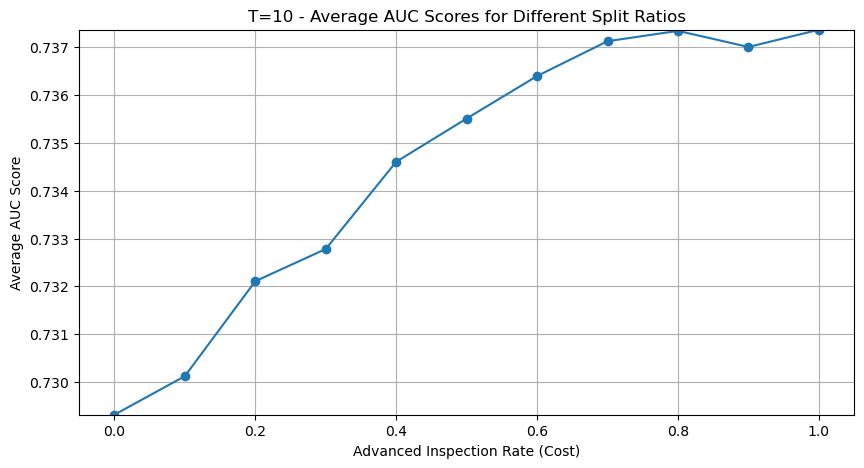

In [14]:
### 필요한 라이브러리 불러오기

import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import warnings 
warnings.filterwarnings('ignore') 
from scipy import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import random 
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader


# 설치된 모듈 경로로 이동하기

%cd /home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module

# 모듈 함수 불러오기

from split_and_predict_uncertainty import split_and_predict_uncertainty
from seed_everything import seed_everything
from test_predict import test_predict

#### Advance inspection ratio에 따른 Test data의 AUC 구하는 함수 만들기


#---------------------------------------------------------------------------------------------------------------------------------------------------------------#


# Define the range of random states

random_states = range(1, 31)

# Advance inspection ratio 정의

split_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

auc_scores_KD_margin_t10 = np.zeros((len(random_states), len(split_ratios)))



# 데이터 업로드

df = pd.read_csv('/home/iai/heo/recipe2/activeinspection_recipe2.csv')
X=df.iloc[:,3:-1].values
Y=df.iloc[:,-1].values
data_X = pd.DataFrame(X)
data_Y = pd.DataFrame(Y)
data_Y = data_Y.rename(columns={0: '0.1'})


# advance model(teacher model)에 사용될 feature

teacher_model_features=len(list(data_X.columns)) # 99

# advance model(teacher model) 정의하기

class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=teacher_model_features,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2)
        )
    def forward(self, x):
        output=self.classifier(x)
        return output



# student model(basic model)에서 사용될 feature

test_stage_features=[0,1,2,3,4,5,6,7]
student_model_features=len(test_stage_features)
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=8,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2),
        )
    def forward(self, x):
        output=self.classifier(x)
        return output  


# 하이퍼파라미터 세팅

learning_rate = 0.01
num_epochs = 200


# loss function - crossentropy()함수

a=986/(244020+986)
b=244020/(244020+986)
weights=[a,b]
weights=torch.FloatTensor(weights)

criterion = nn.CrossEntropyLoss(weights)

# 30회 반복시 preliminary experiment( AUC 평균, 표준편차 )의 결과를 계산하기 위한 리스트

auc_score30_split_KD_t10=[]
auc_score30_split_KD_0_2_t10=[]
auc_score30_split_ad_KD_t10=[]


#-------------------------------------------------------------------------------------------------------------------------------------------------
# 학습이 다음 순으로 진행됩니다.

# 1.기본 설정

#여러 다양한 초기 랜덤 상태에 대해 실험을 진행합니다. 이 때, random_states 값은 1부터 30까지 설정됩니다.

# 2.데이터 처리

# 데이터를 학습, 검증, 테스트 데이터로 분리합니다.
# 데이터를 정규화합니다.
# 데이터를 PyTorch의 Tensor로 변환하고 DataLoader를 설정합니다.

# 3.선생님 모델 학습 (Advance 모델)

# 이 모델은 주어진 데이터로 학습을 진행하며, 각 에포크마다 학습 및 검증 손실을 계산합니다.
# 조기 종료(early stopping) 메커니즘이 적용됩니다. 연속적으로 모델 성능 향상이 없을 경우 학습이 조기 종료될 수 있습니다.

# 4.학생 모델 학습 (기본 모델)

# 학생 모델도 같은 방식으로 학습되지만, 선생님 모델과는 다른 입력 특성을 사용할 수 있습니다.
# 학생 모델도 조기 종료 메커니즘을 사용합니다.

# 5. 불확실성 평가

# 테스트 데이터를 사용하여 학생 모델의 예측값을 생성합니다.
# 이 예측값의 불확실성을 평가하기 위해 Biased Margin을 계산합니다. Biased Margin은 예측 확률의 차이를 의미합니다.
# 불확실성 점수를 기준으로 데이터를 여러 비율로 분할합니다. 예를 들어, 가장 불확실성이 높은 상위 10% 데이터, 상위 20% 데이터 등으로 분할됩니다.

# 6.분할 데이터의 성능 평가

# 분할된 각 데이터 집합에 대해 선생님 모델의 성능 (AUC)을 평가합니다.

#-------------------------------------------------------------------------------------------------------------------------------------------------------------


random_states=range(1, 31)

# 30회 반복 실험
for i,random_state in enumerate(random_states):

    # 데이터 분할
    
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_Y, test_size=0.5, random_state=random_state, shuffle=True, stratify=data_Y)
    train_X, val_X, train_y, val_y=train_test_split(train_X,train_y,test_size=1/5, random_state=random_state,shuffle=True, stratify=train_y)
    
    # 데이터 정규화
    
    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    val_X_scaled=scaler.transform(val_X)
    test_X_scaled = scaler.transform(test_X)
    
    # 데이터들을 파이토치 텐서로 변환 

    train_X_tensor=torch.tensor(train_X_scaled,dtype=torch.float32)
    train_y_tensor=torch.tensor(np.array(train_y),dtype=torch.long)
    val_X_tensor=torch.tensor(val_X_scaled, dtype=torch.float32)
    val_y_tensor=torch.tensor(np.array(val_y),dtype=torch.long)
    test_X_tensor=torch.tensor(test_X_scaled,dtype=torch.float32)
    test_y_tensor=torch.tensor(np.array(test_y),dtype=torch.long)
    
    train_tensorboard=TensorDataset(train_X_tensor,train_y_tensor)
    val_tensorboard=TensorDataset(val_X_tensor,val_y_tensor)
    test_tensorboard=TensorDataset(test_X_tensor,test_y_tensor)
    
    # 배치사이즈의 크기는 학습 데이터셋의 절반 크기로 함
    
    batch_size=4900
    
    # 데이터 로더 만들어주기
    
    train_loader=DataLoader(train_tensorboard,batch_size=batch_size,shuffle=True,drop_last=True)
    val_loader=DataLoader(val_tensorboard,batch_size=batch_size,shuffle=False)
    test_loader=DataLoader(test_tensorboard,batch_size=batch_size,shuffle=False)
    
    #--------------------------------------------------------------------------------------------------------#
    
    # advance model 로드하기
    
    best_teacher_model=torch.load('/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/advance_model_recipe2/advancemodel_randomstate{}'.format(i))

    # basic model 로드하기
    
    best_student_model=torch.load('/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/temperature10_kd_model_recipe2/temperature10_kd_basicmodel_randomstate{}'.format(i))
            
    #### Best student model로 test data 예측하기
    
    y_predictions=test_predict(best_student_model,"best_student_model",test_loader)

    # 테스트 데이터의 입력(X)와 라벨(y)을 결합
    
    test_data=pd.concat([test_X,test_y],axis=1)
 
   

    # Margin을 계산하여 uncertainty score로 사용 
    
    # Margin은 예측 확률 사이의 차이로 계산 (예: abs(probability of class 1- probability of class 0))
    
    uncertainty_scores=1/np.abs(y_predictions-0.5)

    test_data['predictions']=y_predictions 
    test_data['uncertainty_scores']=uncertainty_scores 
        
    # Uncertainty 기준으로 데이터프레임 정렬하기
    test_data=test_data.sort_values(by='uncertainty_scores',ascending=False)
        
    test_y=test_data['0.1']   
    # split_ratios에 대해 반복
    for j, split_ratio in enumerate(split_ratios):
        # 주어진 분할 비율에 따른 AUC를 계산
        auc_score = split_and_predict_uncertainty(test_data, best_teacher_model, test_y, split_ratio,scaler,batch_size)
        # 결과 AUC를 저장
        auc_scores_KD_margin_t10[i, j] = auc_score
        # 분할 비율이 0일 때의 결과 출력 (Basic 모델)
        if split_ratio==0:
            auc_score30_split_KD_t10.append(auc_score)
            print("Random State가 ",i+1," 일 때 ", "T=10일 때 KD model: ",auc_score)
        if split_ratio==0.2:
            auc_score30_split_KD_0_2_t10.append(auc_score)
            print("Split_ratio: ",split_ratio, "이고 Random State가 ",i+1," 일 때 ", "model split ratio 0.2: ",auc_score)
        # 분할 비율이 1일 때의 결과 출력 (Advance 모델)
        if split_ratio==1:
            auc_score30_split_ad_KD_t10.append(auc_score)
            print("Random State가 ", i+1," 일 때 ","Advance model: ",auc_score)
            
# Calculate the average AUC scores

average_auc_scores_KD_margin_t10 = auc_scores_KD_margin_t10.mean(axis=0)   


plt.figure(figsize=(10, 5))
plt.plot(split_ratios, average_auc_scores_KD_margin_t10, marker='o')
plt.title('T=10 - Average AUC Scores for Different Split Ratios')
plt.xlabel('Advanced Inspection Rate (Cost)')
plt.ylabel('Average AUC Score')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim(min(average_auc_scores_KD_margin_t10), max(average_auc_scores_KD_margin_t10))
plt.grid()
plt.show()   

In [17]:
average_auc_scores_KD_margin_t10

array([0.72931338, 0.73011967, 0.73210693, 0.73278105, 0.73460635,
       0.7355114 , 0.73640076, 0.73712965, 0.73734567, 0.73700885,
       0.73736964])

In [18]:
# T가 10일 때 KD 모델의 30회 반복 실험 평균값

print(np.mean(np.array(auc_score30_split_KD_t10)))

# KD 모델의 30회 반복 실험 표준편차

print(np.std(np.array(auc_score30_split_KD_t10)))

0.7293133819100274
0.009806401812262715


### Biased_Margin - VM

/home/iai/heo/recipe1_total_25_new/pytorch_module
Random state가  1 일 때 , VM model:  0.7205499399593656
Random state가  1 일 때 , Advance model:  0.740309717572114
Random state가  2 일 때 , VM model:  0.7340860482123883
Random state가  2 일 때 , Advance model:  0.7450225873481923
Random state가  3 일 때 , VM model:  0.7352047923448565
Random state가  3 일 때 , Advance model:  0.7469992483906732
Random state가  4 일 때 , VM model:  0.7075326433024394
Random state가  4 일 때 , Advance model:  0.7209551373519911
Random state가  5 일 때 , VM model:  0.7365197179827477
Random state가  5 일 때 , Advance model:  0.7414434490040304
Random state가  6 일 때 , VM model:  0.7431921917084241
Random state가  6 일 때 , Advance model:  0.7588938525140011
Random state가  7 일 때 , VM model:  0.7259958158585411
Random state가  7 일 때 , Advance model:  0.7353560701388988
Random state가  8 일 때 , VM model:  0.7278048901322058
Random state가  8 일 때 , Advance model:  0.7376362593230062
Random state가  9 일 때 , VM model:  0.7349505236244893
Random sta

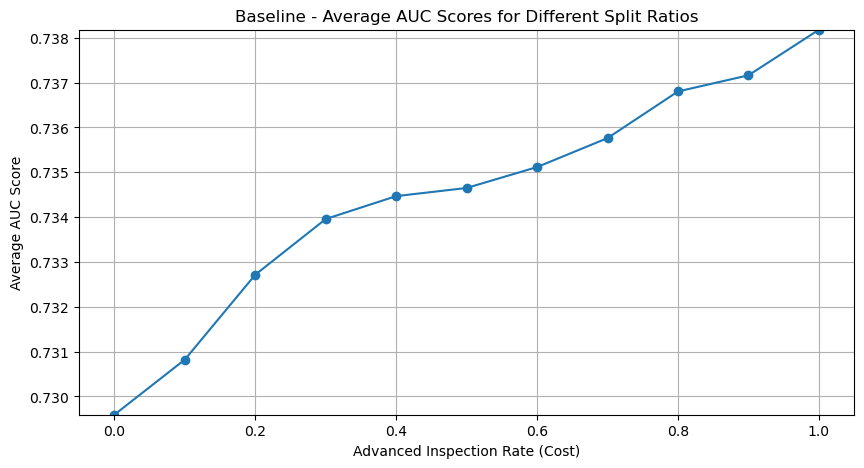

In [9]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import warnings 
warnings.filterwarnings('ignore') 
from scipy import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import random 
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset,DataLoader

# 설치된 모듈 경로로 이동하기

%cd /home/iai/heo/recipe1_total_new_MinMaxscaler/pytorch_module

from split_and_predict_randomsampling import split_and_predict
from seed_everything import seed_everything
from virtual_features import virtual_features
from test_predict import test_predict

#---------------------------------------------------------------------------------------------------------------------------------------------------------------

# Define the range of random states

random_states = range(1, 31)

# Advance inspection ratio 정의
split_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# 데이터 업로드

df = pd.read_csv('/home/iai/heo/recipe2/activeinspection_recipe2.csv')
X=df.iloc[:,3:-1].values
Y=df.iloc[:,-1].values
data_X = pd.DataFrame(X)
data_Y = pd.DataFrame(Y)
data_Y = data_Y.rename(columns={0: '0.1'})

# 난수 고정

seed_everything(42)

# advance model(teacher model)에 사용될 feature

teacher_model_features=len(list(data_X.columns)) # 99

# advance model(teacher model) 정의하기

class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=teacher_model_features,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2)
        )
    def forward(self, x):
        output=self.classifier(x)
        return output



# student model(basic model)에서 사용될 feature

test_stage_features=[0,1,2,3,4,5,6,7]
student_model_features=len(test_stage_features)
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.classifier=nn.Sequential(
            nn.Linear(in_features=8,out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10,out_features=2),
        )
    def forward(self, x):
        output=self.classifier(x)
        return output  


# 하이퍼파라미터 세팅

learning_rate = 0.01
num_epochs = 200

auc_score30_split_VM=[]
auc_score30_split_VM_0_2=[]
auc_score30_split_ad_VM=[]

random_states=range(1, 31)
auc_scores_VM_margin = np.zeros((len(random_states), len(split_ratios)))
# 30회 반복 실험
for i,random_state in enumerate(random_states):

    # 데이터 분할
    
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_Y, test_size=0.5, random_state=random_state, shuffle=True, stratify=data_Y)
    train_X2, val_X, train_y2, val_y=train_test_split(train_X,train_y,test_size=1/5, random_state=random_state,shuffle=True, stratify=train_y)
    
    # 데이터 정규화
    
    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X2)
    val_X_scaled=scaler.transform(val_X)
    test_X_scaled = scaler.transform(test_X)
    
    # 데이터들을 파이토치 텐서로 변환 

    train_X_tensor=torch.tensor(train_X_scaled,dtype=torch.float32)
    train_y_tensor=torch.tensor(np.array(train_y2),dtype=torch.long)
    val_X_tensor=torch.tensor(val_X_scaled, dtype=torch.float32)
    val_y_tensor=torch.tensor(np.array(val_y),dtype=torch.long)
    test_X_tensor=torch.tensor(test_X_scaled,dtype=torch.float32)
    test_y_tensor=torch.tensor(np.array(test_y),dtype=torch.long)
    
    train_tensorboard=TensorDataset(train_X_tensor,train_y_tensor)
    val_tensorboard=TensorDataset(val_X_tensor,val_y_tensor)
    test_tensorboard=TensorDataset(test_X_tensor,test_y_tensor)
    
    # 배치사이즈의 크기는 학습 데이터셋의 절반 크기로 함
     
    batch_size=4900
    
    # 데이터 로더 만들어주기
    
    train_loader=DataLoader(train_tensorboard,batch_size=batch_size,shuffle=True,drop_last=True)
    val_loader=DataLoader(val_tensorboard,batch_size=batch_size,shuffle=False)
    test_loader=DataLoader(test_tensorboard,batch_size=batch_size,shuffle=False)

    best_teacher_model=torch.load('/home/iai/heo/recipe2_total_module_MinMaxScaler/pytorch/advance_model_recipe2/advancemodel_randomstate{}'.format(i))    
    
    # 가상계측 변수 만들기

    test_X_new=virtual_features(train_X,test_X,num_features=88)

    # 가상계측 변수 Scaling해주기   

    test_X_new_scaled=scaler.transform(test_X_new)
    
    # 가상계측 변수가 포함된 VM model로 test data 예측하기
    
    test_X_new_tensor=torch.tensor(test_X_new_scaled,dtype=torch.float32)
    test_new_tensorboard=TensorDataset(test_X_new_tensor,test_y_tensor)
    test_new_loader=DataLoader(test_new_tensorboard,batch_size=batch_size,shuffle=False)    
       
    y_predictions=test_predict(best_teacher_model,"best_teacher_model",test_new_loader)

    test_data=pd.concat([test_X,test_y],axis=1)

    # Margin을 계산하여 uncertainty score로 사용 
    
    # Margin은 예측 확률 사이의 차이로 계산 (예: abs(probability of class 1- probability of class 0))
    
    uncertainty_scores=1/np.abs(y_predictions-0.5)

    test_data['predictions']=y_predictions 
    test_data['uncertainty_scores']=uncertainty_scores 
        
    # Uncertainty 기준으로 데이터프레임 정렬하기
    test_data=test_data.sort_values(by='uncertainty_scores',ascending=False)
        
    test_y=test_data['0.1']     
    # Loop through the split_ratios
    for j, split_ratio in enumerate(split_ratios):
        auc_score = split_and_predict_uncertainty(test_data, best_teacher_model, test_y, split_ratio,scaler,batch_size)
        auc_scores_VM_margin[i, j] = auc_score
        if split_ratio==0:
            auc_score30_split_VM.append(auc_score)
            print('Random state가 ',i+1,'일 때 , VM model: ',auc_score)
        if split_ratio==1:
            auc_score30_split_ad_VM.append(auc_score)
            print('Random state가 ',i+1,'일 때 , Advance model: ',auc_score)    
    
# Calculate the average AUC scores

average_auc_scores_VM_margin = auc_scores_VM_margin.mean(axis=0)   


plt.figure(figsize=(10, 5))
plt.plot(split_ratios, average_auc_scores_VM_margin, marker='o')
plt.title('Baseline - Average AUC Scores for Different Split Ratios')
plt.xlabel('Advanced Inspection Rate (Cost)')
plt.ylabel('Average AUC Score')
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim(min(average_auc_scores_VM_margin), max(average_auc_scores_VM_margin))
plt.grid()
plt.show()    

In [ ]:
average_auc_scores_VM_margin

In [ ]:
#VM 모델의 30회 반복 실험 평균값

print(np.mean(np.array(auc_score30_split_VM)))

# VM 모델의 30회 반복 실험 표준편차

print(np.std(np.array(auc_score30_split_VM)))

In [19]:

split_ratios = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
average_auc_scores_Baseline_margin=[0.72816782, 0.72893296, 0.72916692, 0.72962509, 0.73179851,0.73365059, 0.7346722 , 0.73539652, 0.73546769, 0.73647016, 0.73736964]
average_auc_scores_KD_margin_t1=[0.72951437, 0.73073556, 0.73245707, 0.73294892, 0.73443452, 0.73682165, 0.73815687, 0.73737545, 0.73777267, 0.73735859, 0.73736964]
average_auc_scores_KD_margin_t2=[0.72974015, 0.73082361, 0.73125072, 0.73267455, 0.73414878, 0.73562508, 0.73675365, 0.73773094, 0.73765165, 0.73720563, 0.73736964]
average_auc_scores_KD_margin_t5=[0.7300797 , 0.73146174, 0.7327415 , 0.73378136, 0.73585433, 0.73758414, 0.73805539, 0.73832528, 0.73801857, 0.73731224, 0.73736964]
average_auc_scores_KD_margin_t10=[0.72931338, 0.73011967, 0.73210693, 0.73278105, 0.73460635, 0.7355114 , 0.73640076, 0.73712965, 0.73734567, 0.73700885, 0.73736964]
#average_auc_scores_VM_margin=[0.72959295, 0.73082239, 0.7327154 , 0.7339571 , 0.73446746, 0.73464938, 0.73511571, 0.73576196, 0.73680219, 0.73716181, 0.73817815]

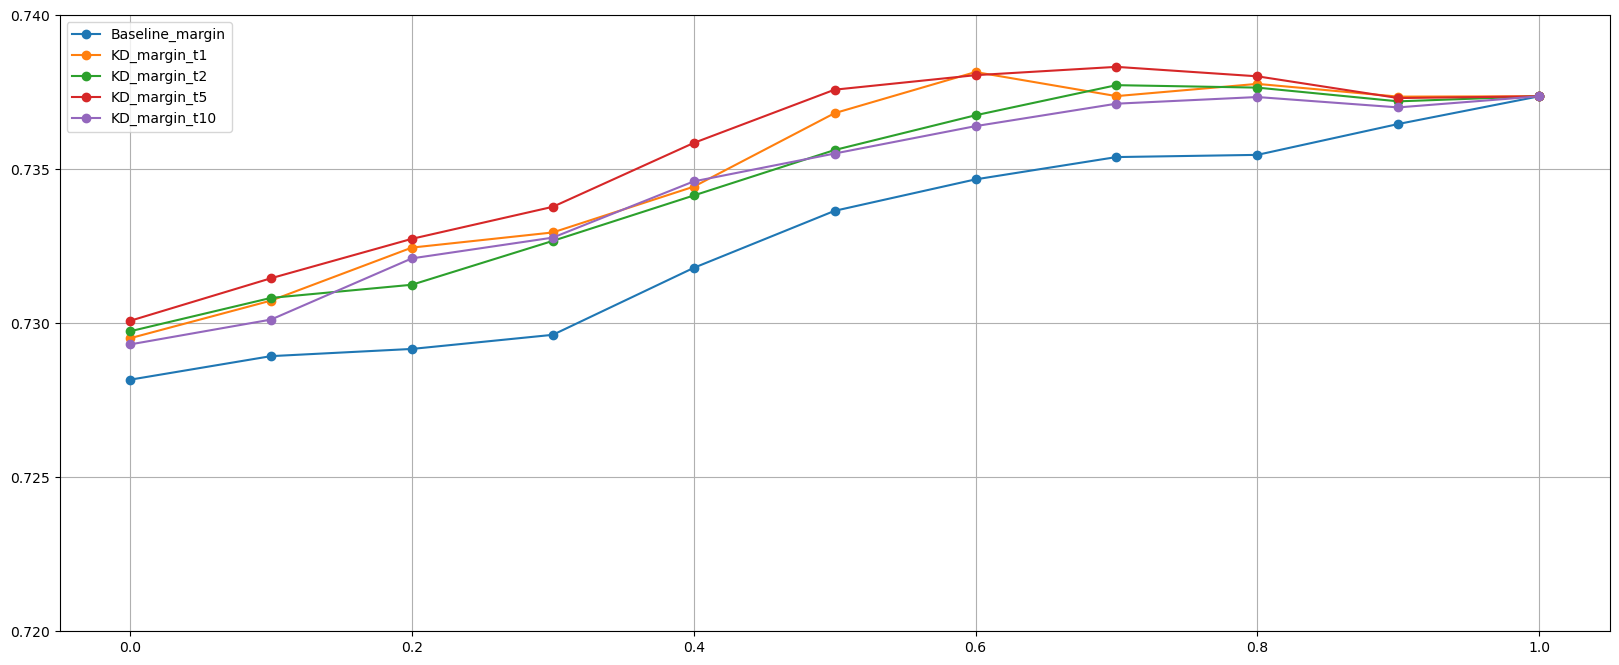

In [21]:
import matplotlib.pyplot as plt 

split_ratio=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

plt.figure(figsize=(20,8))
plt.plot(split_ratio,average_auc_scores_Baseline_margin,marker='o',label='Baseline_margin')
plt.plot(split_ratio,average_auc_scores_KD_margin_t1,marker='o',label='KD_margin_t1')
plt.plot(split_ratio,average_auc_scores_KD_margin_t2,marker='o',label='KD_margin_t2')
plt.plot(split_ratio,average_auc_scores_KD_margin_t5,marker='o',label='KD_margin_t5')
plt.plot(split_ratio,average_auc_scores_KD_margin_t10,marker='o',label='KD_margin_t10')
#plt.plot(split_ratio,average_auc_scores_VM_margin,marker='o',label='VM_margin')
plt.legend()
plt.yticks([0.720,0.725,0.73,0.735,0.740])
plt.grid()
plt.show()